In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Importing the dataset
df = pd.read_csv("2_shopping_trends.csv")
df

,Age,Gender,Item Purchased,Category,Location,Season,Review Rating,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,Purchase Intent Category
0,33,Male,Backpack,Accessories,Malaysia,Summer,4.5,Yes,Yes,44,Fortnightly,Wants-based
1,39,Female,Jeans,Clothing,Spain,Winter,5.0,No,No,23,Fortnightly,Wants-based
2,23,Male,Dress,Clothing,Australia,Spring,3.2,No,No,30,Weekly,Wants-based
3,39,Male,Backpack,Accessories,United Kingdom,Fall,3.1,Yes,Yes,19,Weekly,Wants-based
4,34,Female,Gloves,Accessories,Nigeria,Winter,2.8,No,No,16,Annually,Wants-based
...,...,...,...,...,...,...,...,...,...,...,...,...
12939,53,Male,Sneakers,Footwear,Canada,Fall,4.4,Yes,Yes,1,NaN,Impulsive
12940,54,Male,Jewelry,Accessories,Thailand,Summer,4.3,Yes,Yes,1,NaN,Impulsive
12941,56,Female,Boots,Footwear,United States,Summer,3.8,No,No,2,NaN,Impulsive
12942,52,Female,Coat,Outerwear,Spain,Spring,3.0,No,No,2,NaN,Impulsive


In [25]:
# Drop unused columns
cleaned_df = df.copy()
cleaned_df.drop(columns=[col for col in df.columns if col not in ['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                                                                  'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 
                                                                  'Frequency of Purchases']], inplace=True)
cleaned_df

,Gender,Item Purchased,Category,Location,Season,Discount Applied,Promo Code Used,Frequency of Purchases,Purchase Intent Category
0,Male,Backpack,Accessories,Malaysia,Summer,Yes,Yes,Fortnightly,Wants-based
1,Female,Jeans,Clothing,Spain,Winter,No,No,Fortnightly,Wants-based
2,Male,Dress,Clothing,Australia,Spring,No,No,Weekly,Wants-based
3,Male,Backpack,Accessories,United Kingdom,Fall,Yes,Yes,Weekly,Wants-based
4,Female,Gloves,Accessories,Nigeria,Winter,No,No,Annually,Wants-based
...,...,...,...,...,...,...,...,...,...
12939,Male,Sneakers,Footwear,Canada,Fall,Yes,Yes,NaN,Impulsive
12940,Male,Jewelry,Accessories,Thailand,Summer,Yes,Yes,NaN,Impulsive
12941,Female,Boots,Footwear,United States,Summer,No,No,NaN,Impulsive
12942,Female,Coat,Outerwear,Spain,Spring,No,No,NaN,Impulsive


In [26]:
#check missing values
print("\nMising Value:\n",cleaned_df.isnull().sum())

#check datatype for each columns
print("\nDatatype for each column\n",cleaned_df.dtypes)

#check duplicate values
df.duplicated().sum()


Mising Value:
 Gender                         0
Item Purchased                 0
Category                       0
Location                       0
Season                         0
Discount Applied               0
Promo Code Used                0
Frequency of Purchases      9044
Purchase Intent Category       0
dtype: int64

Datatype for each column
 Gender                      object
Item Purchased              object
Category                    object
Location                    object
Season                      object
Discount Applied            object
Promo Code Used             object
Frequency of Purchases      object
Purchase Intent Category    object
dtype: object


np.int64(2056)

In [28]:
# handle missing values
cleaned_df['Frequency of Purchases'] = cleaned_df['Frequency of Purchases'].fillna(cleaned_df['Frequency of Purchases'].mode()[0])

# check missing values
print("\nMissing Value:\n",cleaned_df.isnull().sum())


Missing Value:
 Gender                      0
Item Purchased              0
Category                    0
Location                    0
Season                      0
Discount Applied            0
Promo Code Used             0
Frequency of Purchases      0
Purchase Intent Category    0
dtype: int64


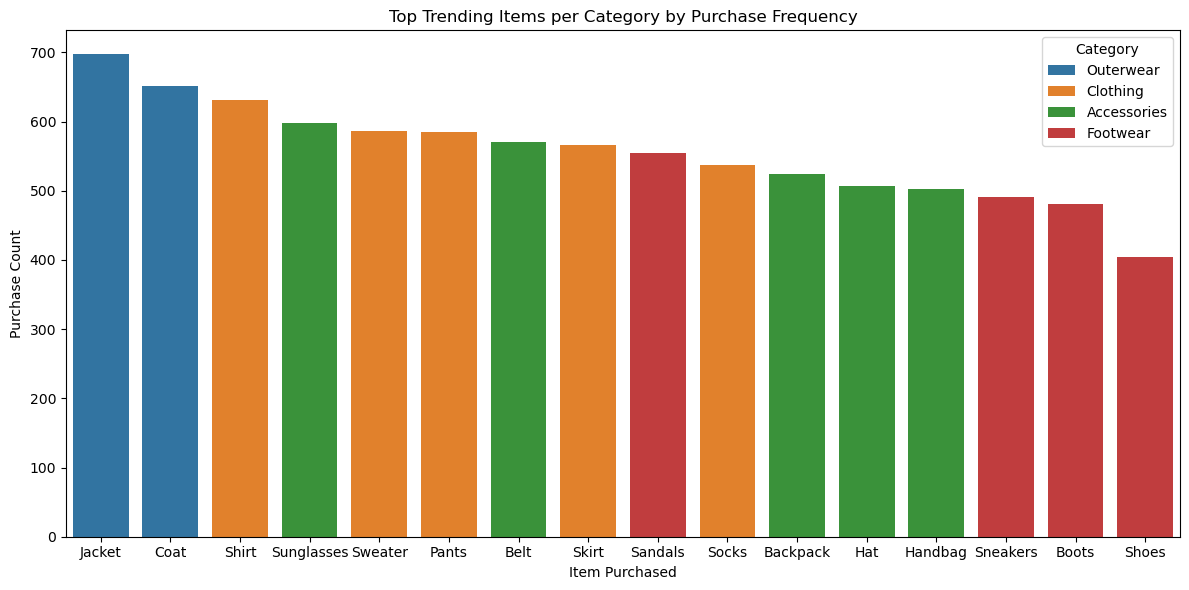

In [ ]:
# rank items by frequency per category
rank_df = cleaned_df.groupby(['Category', 'Item Purchased'])['Frequency of Purchases'].count().reset_index(name='Purchase Count')
top_items = rank_df.sort_values(by='Purchase Count', ascending=False).groupby('Category').head(5)

# visualize
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_items,
    x='Item Purchased',
    y='Purchase Count',
    hue='Category',
    dodge=False,
    palette='tab10'
)
plt.title('Top Trending Items per Category by Purchase Frequency')
plt.xlabel('Item Purchased')
plt.ylabel('Purchase Count')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

### Clustering using KMeans

In [42]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert categorical variables to numerical format using label encoding
cluster_df = cleaned_df[['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                         'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 
                         'Frequency of Purchases']].copy()

le_dict = {}  # Store label encoders

for column in cluster_df.columns:
    le = LabelEncoder()
    cluster_df[column] = le.fit_transform(cluster_df[column].astype(str))
    le_dict[column] = le

In [36]:
from sklearn.cluster import KMeans
import plotly.express as px
kmeans = KMeans(n_clusters=5)
cleaned_df['Cluster'] = kmeans.fit_predict(cluster_df)

In [37]:
top_items_per_cluster = (    
    cleaned_df.groupby(['Cluster', 'Item Purchased'])    
    .size()    
    .reset_index(name='Count')    
    .sort_values(['Cluster', 'Count'], ascending=[True, False])    
    .groupby('Cluster')    
    .head(5))

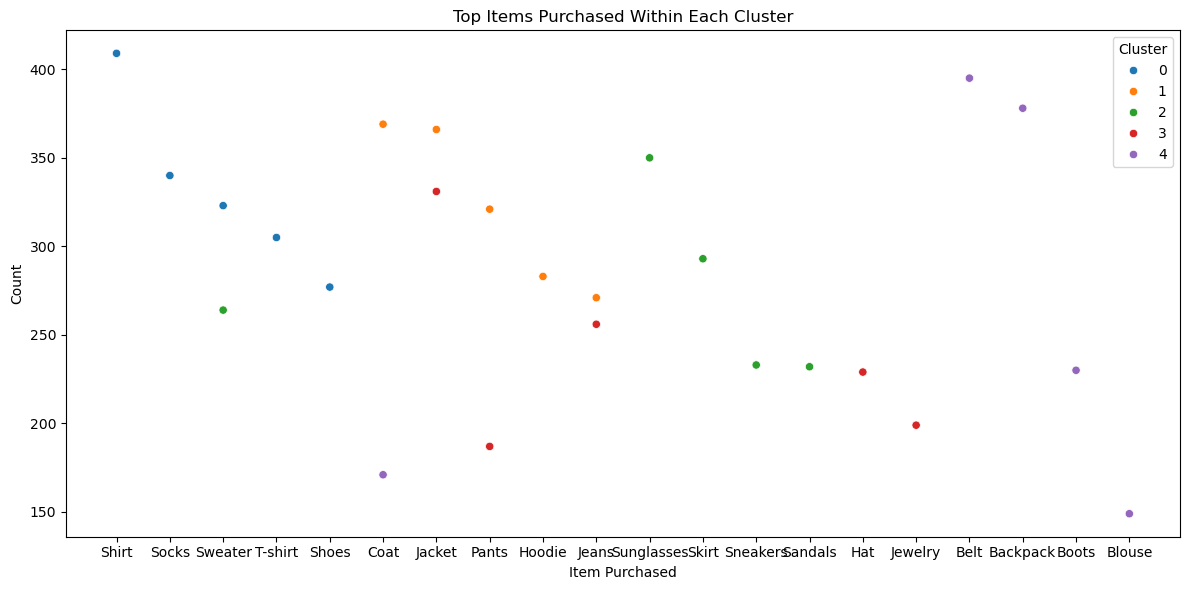

In [44]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=top_items_per_cluster,
    x='Item Purchased',
    y='Count',
    hue='Cluster',
    palette='tab10'
)
plt.title('Top Items Purchased Within Each Cluster')
plt.xlabel('Item Purchased')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import silhouette_score
# After fitting KMeans
inertia = kmeans.inertia_
silhouette = silhouette_score(cluster_df, kmeans.labels_)
print(f"Inertia: {inertia}")
print(f"Silhouette Score: {silhouette}")

Inertia: 349160.1351201997
Silhouette Score: 0.28641726465476186


In [ ]:
# Association Rule Mining
# Prepare data for Apriori
apriori_df = df[['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                 'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 'Frequency of Purchases']].astype(str)

transactions = apriori_df.values.tolist()
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
trans_df = pd.DataFrame(te_array, columns=te.columns_)
